In [66]:
import pandas as pd
clean_multiple_df = pd.read_parquet("cleaned_multiple.parquet")
clean_multiple_df.head(2)

,DOI,proc_ref_ptge,proc_refs,ref_count,type
0,10.4018/978-1-6684-8276-6.ch010,49,"[Althusser, L. (2014). On the reproduction of ...",70,book-chapter
1,10.3390/jcm12134438,99,"[Tsao, Benjamin, Heidenreich, Virani, Bozkurt,...",170,journal-article


In [124]:
import pandas as pd
t = pd.read_csv("/Users/eshadatta/sneaked_references_explorations/data/2024_4_15T10_44_29/part-00000-cc49e860-09a1-4023-95de-950ca0c0d5ba-c000.csv")
t

,DOI,vocabulary,tf_idf_value
0,10.59368/agingbio.20230005,[arxiv],1.000000
1,10.1021/cr900204u,[katritzky],0.998520
2,10.1016/j.jpolmod.2009.09.003,[onishi],0.996450
3,10.1016/j.prostr.2024.01.061,[zanarini],0.995688
4,10.1016/j.cageo.2023.105411,[vermeesch],0.995591
...,...,...,...
2161,10.1016/j.tetlet.2009.09.153,[ranu],0.750000
2162,10.1016/j.chroma.2009.09.079,[bicchi],0.750000
2163,10.1080/09654310220145350,[sotarauta],0.750000
2164,10.1103/physrevd.65.114504,[fujikawa],0.750000


In [88]:
import pandas as pd
clean_refs_multiple_df = pd.read_parquet("cleaned_refs_multiple.parquet")
clean_refs_multiple_df.head(2)

,DOI,proc_ref_ptge,proc_refs,ref_count,type
0,10.4018/978-1-6684-8276-6.ch010,49,"[Althusser, L. (). On the reproduction of capi...",70,book-chapter
1,10.3390/jcm12134438,99,"[Tsao, Benjamin, Heidenreich, Virani, Bozkurt,...",170,journal-article


In [113]:
from stopwordsiso import stopwords
import calendar
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import numpy as np
from scipy.sparse import issparse
from contextlib import suppress 

def get_stopwords():
    months = [x.lower() for x in list(calendar.month_name)[1:]]
    eng_stopwords = stopwords('en')
    domain_stopwords = ["book","review", "last accessed", "accessed", "et al", "studies","journal","revue","conference", "annals","proceedings","advances","bulletin","société","del","acta","études","tijdschrift","voor","anales","журнал","zeitschrift","annales","archiv","archiv"]
    all_stopwords = list(eng_stopwords) + list(stopwords('es')) + list(stopwords('de')) + list(stopwords('fr')) + list(stopwords('ru')) + domain_stopwords + months
    return all_stopwords


def clean_text(doi, text):
    X = None
    all_stopwords = get_stopwords()
    clean_text = re.sub(r"doi\:.*?\s","",text[0])
    clean_text = re.sub(r'<.*?>','',clean_text)
    clean_text = re.sub(r"http.*?\s","",clean_text)
    clean_text = re.sub(r"\d+", "",clean_text)
    vectorizer = TfidfVectorizer(stop_words=all_stopwords)
    try:
        X = vectorizer.fit_transform([clean_text])
    except Exception as e:
        print(f"ERROR: {doi}. Exception: {e}")
    return [X, vectorizer, clean_text]


def get_highest_tf_idf_vocab(result_idf, vectorizer):
    features = vectorizer.get_feature_names_out()
    # converting from sparse matrix, to numpy array
    # since there is only one document of all concatenated refs
    # getting the values from the first index
    ar_refs_idf = result_idf.toarray()[0]
    highest_value = max(ar_refs_idf)
    # getting all positions where the value is the highest value
    position = np.where(ar_refs_idf == highest_value)[0]
    # get vocabulary from features that match the position 
    vocab = list(map(lambda x: features[x], position))
    return {"vocabulary": vocab, "tf_idf_value": highest_value}

def get_proc_refs_info(doi, refs):
    refs1_info = {"vocabulary": None, "tf_idf_value": None}
    refs = [r[:50] for r in refs]
    process_refs = [" ".join(refs)]
    has_chars = re.findall(r"\w{2,10}",process_refs[0])
    match_ptge = (len(has_chars)/len(refs)) * 100
    if match_ptge >= 30:
        refs1_idf, vect1, cleaned1_txt = clean_text(doi, process_refs)
        if issparse(refs1_idf):
            refs1_info = get_highest_tf_idf_vocab(refs1_idf, vect1, cleaned_text)
    return refs1_info

import pandas as pd
def get_values(row):
    doi = row.iloc[0]
    refs = row.iloc[2]
    v = get_proc_refs_info(doi, refs)
    return v

In [91]:
#clean_refs_multiple_df.loc[clean_refs_multiple_df.DOI == "10.31450/ukrjnd.1(81).2024.10"].proc_refs.tolist()

In [120]:
doi = clean_multiple_2tf_idf_values.loc[12310].DOI
refs = clean_multiple_2tf_idf_values.loc[12310].proc_refs.tolist()
print(doi)

10.1007/978-981-99-1612-2_6


In [93]:
clean_refs_tf_idf_results = clean_refs_multiple_df.apply(get_values, axis=1)

/Users/eshadatta/sneaked_references_explorations/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'daren', 'hadn', 'herse', 'himse', 'itse', 'mayn', 'mightn', 'mustn', 'myse', 'needn', 'oughtn', 'quelqu', 'shan', 'хотел'] not in stop_words.
  warnings.warn(


ERROR: 10.59368/agingbio.20230008. Exception: empty vocabulary; perhaps the documents only contain stop words
ERROR: 10.59368/agingbio.20230001. Exception: empty vocabulary; perhaps the documents only contain stop words
ERROR: 10.59368/agingbio.20230009. Exception: empty vocabulary; perhaps the documents only contain stop words
ERROR: 10.59368/agingbio.20240025. Exception: empty vocabulary; perhaps the documents only contain stop words
ERROR: 10.59368/agingbio.20240023. Exception: empty vocabulary; perhaps the documents only contain stop words


In [94]:
clean_refs_no_results = np.where(clean_refs_tf_idf_results == {'vocabulary': None, 'tf_idf_value': None})
print(clean_refs_no_results)
print(len(no_results[0]))

(array([12310, 14216, 17356, 50629, 50719, 50984, 51010, 51775, 51842,
       51849, 68094, 69271]),)
12


In [68]:
tf_idf_results_take2 = clean_multiple_df.apply(get_values, axis=1)

/Users/eshadatta/sneaked_references_explorations/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'daren', 'hadn', 'herse', 'himse', 'itse', 'mayn', 'mightn', 'mustn', 'myse', 'needn', 'oughtn', 'quelqu', 'shan', 'хотел'] not in stop_words.
  warnings.warn(


ERROR: 10.59368/agingbio.20230008. Exception: empty vocabulary; perhaps the documents only contain stop words
ERROR: 10.59368/agingbio.20230001. Exception: empty vocabulary; perhaps the documents only contain stop words
ERROR: 10.59368/agingbio.20230009. Exception: empty vocabulary; perhaps the documents only contain stop words
ERROR: 10.59368/agingbio.20240025. Exception: empty vocabulary; perhaps the documents only contain stop words
ERROR: 10.59368/agingbio.20240023. Exception: empty vocabulary; perhaps the documents only contain stop words


In [71]:
no_results2 = np.where(tf_idf_results_take2 == {'vocabulary': None, 'tf_idf_value': None})
print(no_results2)
print(len(no_results2[0]))

(array([12311, 14218, 17358, 50632, 50722, 50987, 51013, 51778, 51845,
       51852, 68097, 69274]),)
12


In [29]:
tf_idf_results = clean_multiple_df.apply(get_values, axis=1)

ERROR: 10.59368/agingbio.20230008. Exception: empty vocabulary; perhaps the documents only contain stop words
ERROR: 10.59368/agingbio.20230001. Exception: empty vocabulary; perhaps the documents only contain stop words
ERROR: 10.59368/agingbio.20230009. Exception: empty vocabulary; perhaps the documents only contain stop words
ERROR: 10.59368/agingbio.20240025. Exception: empty vocabulary; perhaps the documents only contain stop words
ERROR: 10.59368/agingbio.20240023. Exception: empty vocabulary; perhaps the documents only contain stop words


In [30]:
no_results = np.where(tf_idf_results == {'vocabulary': None, 'tf_idf_value': None})
no_results

(array([12311, 14218, 17358, 50632, 50722, 50987, 51013, 51778, 51845,
        51852, 68097, 69274]),)

In [33]:
no_results_indices = no_results[0].tolist()

In [96]:
for i in clean_refs_no_results[0].tolist():
    print("DOI: ", clean_refs_multiple_df.loc[i].DOI)
    print("REFS: ", clean_refs_multiple_df.loc[i].proc_refs.tolist())

DOI:  10.59368/agingbio.20230008
REFS:  ['PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ']
DOI:  10.59368/agingbio.20230001
REFS:  ['PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: ', 'PMID: '

In [42]:
tf_idf_results.index

RangeIndex(start=0, stop=118051, step=1)

In [39]:
clean_multiple_df = clean_multiple_df.drop(['tf_idf_results','vocab_highest_value'], axis=1)
clean_multiple_df

,DOI,proc_ref_ptge,proc_refs,ref_count,type
0,10.4018/978-1-6684-8276-6.ch010,49,"[Althusser, L. (2014). On the reproduction of ...",70,book-chapter
1,10.3390/jcm12134438,99,"[Tsao, Benjamin, Heidenreich, Virani, Bozkurt,...",170,journal-article
2,10.1080/13876988.2023.2223542,69,"[Adie, 2008, 20 Years of Microcredit in France...",45,journal-article
3,10.1016/j.exer.2023.109545,100,"[Alimanović-Halilović, Ashby, Ashwin, Badmus, ...",78,journal-article
4,10.1080/07036337.2023.2232940,48,"[Biscop, S. 2016. “The EU Global Strategy: Rea...",71,journal-article
...,...,...,...,...,...
118046,10.1007/978-3-031-42700-8_17,100,[European Commission – A European Green Deal –...,125,book-chapter
118047,10.1007/978-981-19-6960-7_60,100,"[A. Aab, P. Abreu, M. Aglietta et al., Phys. R...",99,book-chapter
118048,10.1016/j.plaphy.2024.108472,100,"[Akhtamov, Bai, Cai, Chen, Cheng, Clifton, Cus...",67,journal-article
118049,10.1038/s41467-024-46208-9,100,"[Tubbs, A. & Nussenzweig, A. Endogenous DNA da...",86,journal-article


In [97]:
import pandas as pd
clean_refs_tf_idf_df = pd.DataFrame.from_records(clean_refs_tf_idf_results)
clean_refs_tf_idf_df

,vocabulary,tf_idf_value
0,"[creswellj, fourth, interpretive, qualitative,...",0.169638
1,[guazzi],0.366508
2,[microfinance],0.582223
3,[chen],0.294174
4,[european],0.738456
...,...,...
118038,[wang],0.490000
118039,[aharonian],0.539164
118040,[wang],0.557086
118041,[dna],0.419982


In [46]:
import pandas as pd
tf_idf_values_df = pd.DataFrame.from_records(tf_idf_results)
tf_idf_values_df

,vocabulary,tf_idf_value
0,"[creswellj, interpretive]",0.182574
1,[guazzi],0.366508
2,[microfinance],0.550791
3,[chen],0.294174
4,[european],0.734847
...,...,...
118046,[wang],0.490102
118047,[aharonian],0.539164
118048,[wang],0.557086
118049,[dna],0.419982


In [98]:
clean_refs_multiple_tf_idf_values = clean_refs_multiple_df.join(clean_refs_tf_idf_df)
clean_refs_multiple_tf_idf_values

,DOI,proc_ref_ptge,proc_refs,ref_count,type,vocabulary,tf_idf_value
0,10.4018/978-1-6684-8276-6.ch010,49,"[Althusser, L. (). On the reproduction of capi...",70,book-chapter,"[creswellj, fourth, interpretive, qualitative,...",0.169638
1,10.3390/jcm12134438,99,"[Tsao, Benjamin, Heidenreich, Virani, Bozkurt,...",170,journal-article,[guazzi],0.366508
2,10.1080/13876988.2023.2223542,69,"[Adie, , Years of Microcredit in France: The ...",45,journal-article,[microfinance],0.582223
3,10.1016/j.exer.2023.109545,100,"[Alimanović-Halilović, Ashby, Ashwin, Badmus, ...",78,journal-article,[chen],0.294174
4,10.1080/07036337.2023.2232940,48,"[Biscop, S. . “The EU Global Strategy: Realpol...",71,journal-article,[european],0.738456
...,...,...,...,...,...,...,...
118038,10.1007/978-3-031-42700-8_17,100,[European Commission – A European Green Deal –...,125,book-chapter,[wang],0.490000
118039,10.1007/978-981-19-6960-7_60,100,"[A. Aab, P. Abreu, M. Aglietta et al., Phys. R...",99,book-chapter,[aharonian],0.539164
118040,10.1016/j.plaphy.2024.108472,100,"[Akhtamov, Bai, Cai, Chen, Cheng, Clifton, Cus...",67,journal-article,[wang],0.557086
118041,10.1038/s41467-024-46208-9,100,"[Tubbs, A. & Nussenzweig, A. Endogenous DNA da...",86,journal-article,[dna],0.419982


In [99]:
only_zeroes = clean_refs_multiple_tf_idf_values[clean_refs_multiple_tf_idf_values.tf_idf_value.isnull()]
only_zeroes

,DOI,proc_ref_ptge,proc_refs,ref_count,type,vocabulary,tf_idf_value
12310,10.59368/agingbio.20230008,100,"[PMID: , PMID: , PMID: , PMID: , PMID: , PMID:...",39,journal-article,None,NaN
14216,10.59368/agingbio.20230001,100,"[PMID: , PMID: , PMID: , PMID: , PMID: , PMID:...",74,journal-article,None,NaN
17356,10.59368/agingbio.20230009,100,"[PMID: , PMID: , PMID: , Yu, PMID: , PMID: , P...",76,journal-article,None,NaN
50629,10.1017/cbo9780511976476.002,100,"[K., H.A., L.S., R.C., K.S., M.A., I.E., R., G...",66,book-chapter,None,NaN
50719,10.1017/cbo9780511842467.003,99,"[M., R., G., R., R., S., G., D. L., J., G., T....",85,book-chapter,None,NaN
50984,10.1017/cbo9780511842474.019,100,"[P., W., T., H., M. K., [] M. Hertweck , Contr...",33,book-chapter,None,NaN
51010,10.1017/cbo9780511842474.015,100,"[P. A., [] D. O. Revin and E. P. Vdovin , On t...",95,book-chapter,None,NaN
51775,10.1017/cbo9780511842474.012,100,"[R. G., Y., S. I., S. N., A. Yu., B. H., R., J...",37,book-chapter,None,NaN
51842,10.1017/cbo9780511842467.015,100,"[P. M., J. N., M., R., I. N., M., V. N., H., M...",59,book-chapter,None,NaN
51849,10.1017/cbo9780511842474.011,100,"[W., T.A., R.W., N.F., A., M.S., L.A., D.J.S.,...",51,book-chapter,None,NaN


In [126]:
clean_refs_multiple_tf_idf_values = clean_refs_multiple_tf_idf_values.dropna()
clean_refs_multiple_tf_idf_values

,DOI,proc_ref_ptge,proc_refs,ref_count,type,vocabulary,tf_idf_value
0,10.4018/978-1-6684-8276-6.ch010,49,"[Althusser, L. (). On the reproduction of capi...",70,book-chapter,"[creswellj, fourth, interpretive, qualitative,...",0.169638
1,10.3390/jcm12134438,99,"[Tsao, Benjamin, Heidenreich, Virani, Bozkurt,...",170,journal-article,[guazzi],0.366508
2,10.1080/13876988.2023.2223542,69,"[Adie, , Years of Microcredit in France: The ...",45,journal-article,[microfinance],0.582223
3,10.1016/j.exer.2023.109545,100,"[Alimanović-Halilović, Ashby, Ashwin, Badmus, ...",78,journal-article,[chen],0.294174
4,10.1080/07036337.2023.2232940,48,"[Biscop, S. . “The EU Global Strategy: Realpol...",71,journal-article,[european],0.738456
...,...,...,...,...,...,...,...
118038,10.1007/978-3-031-42700-8_17,100,[European Commission – A European Green Deal –...,125,book-chapter,[wang],0.490000
118039,10.1007/978-981-19-6960-7_60,100,"[A. Aab, P. Abreu, M. Aglietta et al., Phys. R...",99,book-chapter,[aharonian],0.539164
118040,10.1016/j.plaphy.2024.108472,100,"[Akhtamov, Bai, Cai, Chen, Cheng, Clifton, Cus...",67,journal-article,[wang],0.557086
118041,10.1038/s41467-024-46208-9,100,"[Tubbs, A. & Nussenzweig, A. Endogenous DNA da...",86,journal-article,[dna],0.419982


In [104]:
clean_refs_multiple_tf_idf_values[clean_refs_multiple_tf_idf_values.DOI == "10.1016/j.jdent.2024.104907"].proc_refs.tolist()

[array(['Cheng', 'Valbuena', 'Barr-Agholme', 'El Housseiny', 'Sreedevi',
        'Amano', 'Vocale', 'Yamazaki-Kubota', 'Martinez-Martinez', 'Ahmed',
        'Sakellari', 'Khocht', 'Cuenca', 'Novoa', 'Reuland-Bosma',
        'Agholme', 'Tanaka', 'Cichon', 'Sakellari',
        'XXX XXX XXX XXX XXX XXX XXX XXX XXX XXX redacted for blind review.',
        'XXX XXX XXX XXX XXX XXX XXX XXX XXX XXX redacted for blind review.',
        'XXX XXX XXX XXX XXX XXX XXX XXX XXX XXX redacted for blind review.',
        'Lang', 'Cai', 'Amplicon', 'Callahan', 'Papapanou',
        'Perez-Chaparro', 'Antonarakis', 'de Graaf', 'Sun', 'Yamaguchi',
        'How', 'Howard', 'Johnson', 'Abusleme', 'Huang', 'Bor', 'Colombo',
        'Curtis', 'Park', 'Holt', 'Huang', 'Bravenec', 'Oliveira',
        'Symanzik', 'Camelo-Castillo', 'Vishwakarma', 'Hanookai',
        'Yoshihara', 'Zaldivar-Chiapa', 'Bay', 'Epstein'], dtype=object)]

In [117]:
clean_refs_multiple_tf_idf_values.sort_values('tf_idf_value', ascending=False)[:50]

,DOI,proc_ref_ptge,proc_refs,ref_count,type,vocabulary,tf_idf_value
17907,10.59368/agingbio.20230005,100,"[PMID: , PMID: , PMID: , PMID: , PMID: , PMID:...",39,journal-article,[arxiv],1.000000
96009,10.1021/cr900204u,100,"[Katritzky A. R., Katritzky A. R., Katritzky A...",211,journal-article,[katritzky],0.998520
87635,10.1016/j.jpolmod.2009.09.003,100,"[Onishi, Onishi, Onishi, Onishi, Onishi, A. (a...",41,journal-article,[onishi],0.996450
116012,10.1016/j.prostr.2024.01.061,100,"[Dirlik, Dirlik, Zanarini, Zanarini, Zanarini,...",27,journal-article,[zanarini],0.995688
25755,10.1016/j.cageo.2023.105411,100,"[Garzanti, Garzanti, Shen, Tian, Vermeesch, Ve...",30,journal-article,[vermeesch],0.995591
98590,10.3109/00498258609038972,100,"[Al-Kassab S., Ashby J., Booth J., Booth J., B...",60,journal-article,[boyland],0.993099
66748,10.1075/hl.15.1-2.15stu,100,"[Stutterheim, Stutterheim, Stutterheim, Stutte...",27,journal-article,[stutterheim],0.992846
20387,10.1016/s1452-3981(23)19585-x,100,"[Al-Mobarak, Sherif, Yao, Abdelhadil, Amar, Me...",59,journal-article,[sherif],0.990742
20386,10.1016/s1452-3981(23)19586-1,100,"[Sherif, Sherif, Osório, Sherif, Diggle, El-Et...",56,journal-article,[sherif],0.989160
48514,10.1016/j.urology.2011.03.066,97,"[Buck, Buck, Buck, Buck, Buck, Buck, Buck, Del...",34,journal-article,[buck],0.988826


In [105]:
clean_refs_multiple_tf_idf_values.to_parquet("cleaned_refs_multiple_tf_idf_values.parquet",compression='gzip')

In [114]:
clean_refs_multiple_tf_idf_values.loc[clean_refs_multiple_tf_idf_values.DOI == "10.1039/b914513c"].proc_refs.tolist()

[array(['Uhl', 'Uhl', 'Uhl', 'Robinson', 'Pardoe', 'Schnepf', 'Brothers',
        'Uhl', 'Uhl', 'Uhl', 'Uhl', 'Uhl', 'Uhl', 'Uhl', 'Uhl', 'Uhl',
        'Tuck', 'Linti', 'Uhl', 'Uhl', 'Kehrwald', 'Cowley', 'Hardman',
        'Hardman', 'Klemp', 'Uhl', 'Linti', 'Neumüller', 'Neumüller'],
       dtype=object)]

In [118]:
clean_refs_multiple_tf_idf_values.loc[clean_refs_multiple_tf_idf_values.DOI == '10.4018/978-1-6684-8276-6.ch010'].vocabulary[0]

['creswellj', 'fourth', 'interpretive', 'qualitative', 'revolution', 'time']

In [123]:
dir = "/Users/eshadatta/sneaked_references_explorations/data/part-00001-93d7ade3-8591-45a9-a896-90c4c90a10ef-c000.json"
import pandas as pd
s = pd.read_json(dir,lines=True)
s

,DOI,proc_ref_ptge,proc_refs,ref_count,type,vocabulary,tf_idf_value
0,10.21203/rs.3.rs-2855147/v1,100,"[Ahn YY, Yun ET, Seo J-W, Lee C, Kim SH, Kim J...",52,posted-content,[wang],0.653275
1,10.19181/socjour.2023.29.2.6,100,[Grinin L. Negative rates and other latest fin...,41,journal-article,[grinin],0.511682
2,10.3390/metabo13070807,98,"[Pathirana, Shu, Q.Y., Forster, B.P., Nakagawa...",65,journal-article,[ali],0.518321
3,10.1016/j.lanwpc.2023.100833,100,"[WHO, National Bureau of Statistics, Walker, L...",36,journal-article,[yang],0.539360
4,10.1007/978-981-99-1718-1_19,100,"[Ai Y, You J, Gao J, Wang J, Sun HB, Ding M, L...",50,book-chapter,[wang],0.548483
...,...,...,...,...,...,...,...
2540,10.1016/j.jwpe.2023.104081,100,"[Li, Jeong, Salahshoori, Salahshoori, Daija, S...",116,journal-article,[salahshoori],0.777714
2541,10.1016/j.vacuum.2023.112454,100,"[Chrisey, Kwok, Dyer, Otis, Roy, Lubben, Diets...",37,journal-article,[novodvorsky],0.593391
2542,10.1038/s41598-023-39494-8,100,"[Dinleyici, M., Carman, K. B., Ozturk, E. & Sa...",36,journal-article,[lee],0.505490
2543,10.3389/fpsyg.2023.1190364,98,"[Adams, Ahn, Baptista, Bolognesi, Christ, Croi...",51,journal-article,[spence],0.842235


In [125]:
import pandas as pd
test = pd.read_json("/Users/eshadatta/sneaked_references_explorations/data/2024_4_16T16_0_20/part-00141-64979186-1c0c-4d94-8304-034dd68e2a67-c000.json", lines=True)
test

,DOI,vocabulary,tf_idf_value
0,10.21511/ppm.22(1).2024.37,[amp],0.827653
1,10.3103/s0146411623080345,[anisimov],0.826754
2,10.1016/j.epsr.2024.110271,[montoya],0.780720


In [129]:
e = clean_refs_multiple_tf_idf_values.sort_values('tf_idf_value', ascending=False)

In [132]:
e.loc[e.vocabulary.apply(lambda x: len(x) > 1)]

,DOI,proc_ref_ptge,proc_refs,ref_count,type,vocabulary,tf_idf_value
15237,10.59368/agingbio.20230007,100,"[PMID: , PMID: , PMID: , PMID: , PMID: , PMID:...",33,journal-article,"[death, organization]",0.707107
27846,10.1590/0037-8682-0144-2023,100,"[Halstead BW, Haddad Jr V, Haddad Jr V, Haddad...",26,journal-article,"[haddad, jr]",0.694341
36357,10.1016/b978-0-12-823794-6.00020-7,83,"[Abi-Hashem, Abi-Hashem, Abi-Hashem, Abi-Hashe...",63,book-chapter,"[abi, hashem]",0.692543
89092,10.1016/j.aca.2009.09.047,100,"[Liger-Belair, Liger-Belair, Liger-Belair, Sha...",29,journal-article,"[belair, liger]",0.688895
66058,10.1075/hl.22.1-2.09dar,100,"[Boas, Clifford, Darnell, Darnell, Darnell, De...",30,journal-article,"[lévi, strauss]",0.688062
...,...,...,...,...,...,...,...
43951,10.1016/j.comptc.2023.114250,100,"[Anzar, Beyer, Zhu, Hosu, Butterfield, Beckett...",87,journal-article,"[ager, alabugin, ali, anzar, bamdad, bandookwa...",0.098058
82115,10.3390/s24051519,100,"[Pillet, Esquenazi, Pinhey, S.R., Murata, H., ...",50,journal-article,"[akarsu, alesi, altenburg, analysis, andrysek,...",0.097590
37492,10.3390/ani13152442,98,"[Fitzgerald, Pietrosemoli, S., and Tang, C. ()...",64,journal-article,"[aarestrup, amin, andersson, animal, ant, asso...",0.090909
35446,10.12677/pi.2023.124047,55,"[李东晓, 马武开, 宁乔怡, 等. 马武开教授从脾论治类风湿关节炎的经验[J]. 风湿病与...",47,journal-article,"[bcl, dpp, erbb, graves病甲状腺功能亢进患者免疫球蛋白和抗核抗体检测的...",0.087706


In [145]:
import pandas as pd
counts = pd.read_csv("/Users/eshadatta/sneaked_references_explorations/binned_data/part-00000-96396335-67e1-4437-a373-6e96e235bc09-c000.csv")
counts.rename({'sum(count)': 'occurrence'}, axis='columns', inplace=True)
counts

,interval bucket,occurrence
0,> 0.95,7
1,0.75-0.85,253
2,0.85-0.95,72


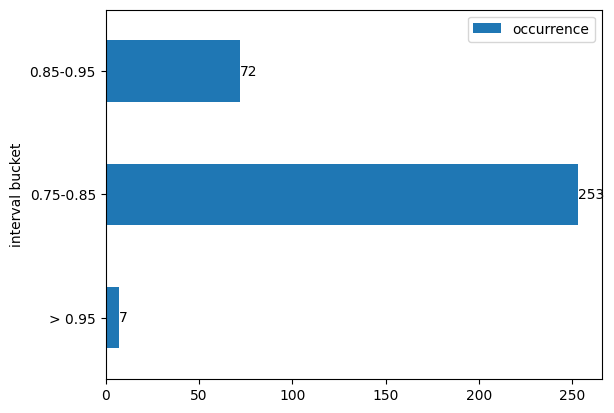

In [154]:
ax = counts.plot.barh(x='interval bucket', y='occurrence')
for container in ax.containers:
    ax.bar_label(container)

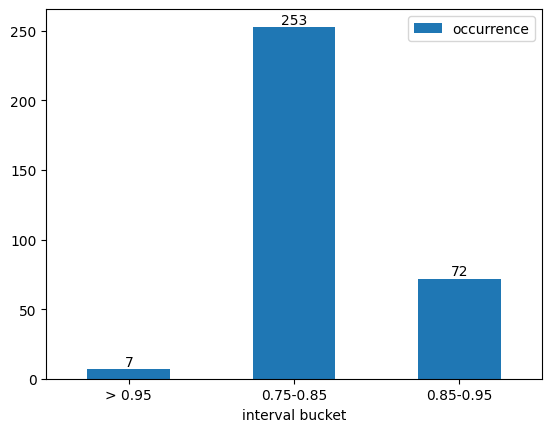

In [151]:
ax = counts.plot.bar(x='interval bucket',y='occurrence', rot=0)
for container in ax.containers:
    ax.bar_label(container)
#ax = counts.plot.bar(x='interval bucket',y='occurrence', rot=0)